In [1]:
from main import Optimisation
%load_ext autoreload
%autoreload 2

In [2]:
import yfinance as yfin

prices = yfin.download(tickers=['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA'], period='1y')['Adj Close']
prices.head()

[*********************100%***********************]  5 of 5 completed


,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
2020-10-30,108.164314,3036.149902,1621.010010,200.629044,388.040009
2020-11-02,108.074875,3004.479980,1626.030029,200.490311,400.510010
2020-11-03,109.734215,3048.409912,1650.209961,204.553009,423.899994
2020-11-04,114.215385,3241.159912,1749.130005,214.422455,420.980011
2020-11-05,118.269310,3322.000000,1763.369995,221.259705,438.089996


In [3]:
industries = {'Tech': ['AAPL', 'GOOG'],
                'Car': ['MSFT', 'TSLA'],
                'Aloner': ['AMZN']}

tickers = prices.columns.tolist()
industryWeights = {'Tech': 0.5,
                    'Car': 0.3,
                    'Aloner': 0.2}

In [50]:
from main import RollingOptimisation
import pandas as pd
import datetime as dt

prices = yfin.download(tickers=['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA'], period='1y', interval='1d')['Adj Close'].ffill()
rollopt = RollingOptimisation(prices, "sharpe", ["weights_constraint","turnover_constraint",])

weights = rollopt.backtest(industries = industries, industryWeights = industryWeights)


[*********************100%***********************]  5 of 5 completed


100%|██████████| 199/199 [00:24<00:00,  8.28it/s]


<AxesSubplot:>

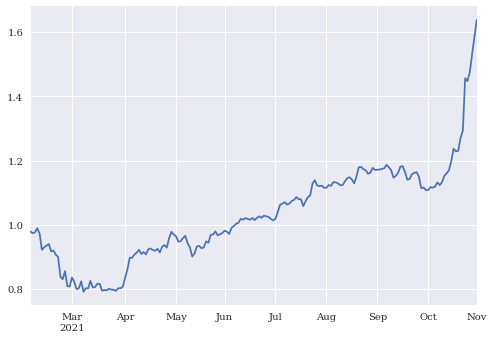

In [51]:
((weights * prices.iloc[63:, ].pct_change()).ffill().dropna().sum(axis=1)+1).cumprod().plot()

<AxesSubplot:>

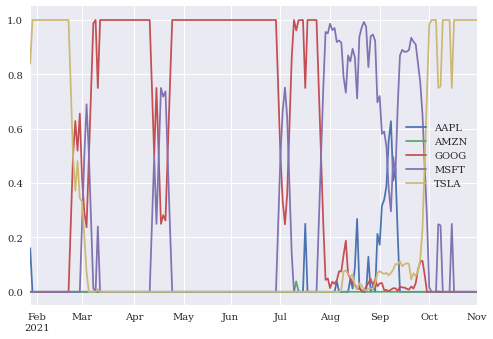

In [52]:
weights.plot()

In [14]:
weights.sum(axis=1)

2021-01-27    1.0
2021-01-28    1.0
2021-01-29    1.0
2021-02-01    1.0
2021-02-02    1.0
             ... 
2021-10-26    1.0
2021-10-27    1.0
2021-10-28    1.0
2021-10-29    1.0
2021-11-01    1.0
Length: 199, dtype: float64

In [56]:
abs(weights.diff()).sum(axis=1)

2021-01-27    0.000000e+00
2021-01-28    3.213357e-01
2021-01-29    7.430927e-12
2021-02-01    7.323791e-12
2021-02-02    6.941669e-14
                  ...     
2021-10-26    2.370326e-14
2021-10-27    7.228246e-14
2021-10-28    9.687390e-14
2021-10-29    1.471046e-15
2021-11-01    5.403664e-15
Length: 199, dtype: float64

In [168]:
for industry in industries:
    print(industry+"weights: ")
    print(pd.DataFrame(weights[industries[industry]].sum(axis=1)).describe()[0][['min','max']])

Techweights: 
min    0.5
max    0.5
Name: 0, dtype: float64
Carweights: 
min    0.3
max    0.3
Name: 0, dtype: float64
Alonerweights: 
min    0.2
max    0.2
Name: 0, dtype: float64
